## Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Actor(nn.Module):
    # Actor provides the next action to take
    def __init__(self, state_dim, action_dim, limit):
        super(Actor, self).__init__()
        self.limit = torch.FloatTensor(limit)

        self.fc1 = nn.Linear(state_dim, 400)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(400, 300)
        nn.init.xavier_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(300, action_dim)
        nn.init.uniform_(self.fc3.weight, -0.003, 0.003)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        return x


class Critic(nn.Module):
    # Critic estimates the state-value function Q(S, A)
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(400 + action_dim, 300)
        nn.init.xavier_uniform_(self.fc2.weight)

        self.fc3 = nn.Linear(300, 1)
        nn.init.uniform_(self.fc3.weight, -0.003, 0.003)

    def forward(self, state, action):
        s = F.relu(self.fc1(state))
        x = torch.cat((s, action), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Constants

In [2]:
TAU = 0.05
A_LEARNING_RATE = 1e-4
C_LEARNING_RATE = 1e-3

## Environment

In [3]:
import numpy as np
from typing import NamedTuple, List


class Experience(NamedTuple):
    """
    An experience contains the data of one Agent transition.
    - Observation
    - Action
    - Reward
    - Done flag
    - Next Observation
    """

    obs: np.ndarray
    action: np.ndarray
    reward: float
    done: bool
    next_obs: np.ndarray

# A Trajectory is an ordered sequence of Experiences
Trajectory = List[Experience]

# A Buffer is an unordered list of Experiences from multiple Trajectories
Buffer = List[Experience]

## DDPG

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import os
import random
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Orn_Uhlen:
    def __init__(self, n_actions, mu=0, theta=0.15, sigma=0.2):
        self.n_actions = n_actions
        self.X = np.ones(n_actions) * mu
        self.mu = mu
        self.sigma = sigma
        self.theta = theta

    def reset(self):
        self.X = np.ones(self.n_actions) * self.mu

    def sample(self):
        dX = self.theta * (self.mu - self.X)
        dX += self.sigma * np.random.randn(self.n_actions)
        self.X += dX
        return self.X

class DDPG:
    def __init__(self, state_dim, n_actions, limit):
        self.env = env

        n_inp = state_dim
        n_out = n_actions
        a_limit = limit

        self.actor_net = Actor(n_inp, n_out, a_limit).to(device)
        self.critic_net = Critic(n_inp, n_out).to(device)

        self.target_actor_net = Actor(n_inp, n_out, a_limit).to(device)
        self.target_critic_net = Critic(n_inp, n_out).to(device)

        if os.path.exists(actor_model_path):
            self.actor_net.load_state_dict(torch.load(actor_model_path))

        if os.path.exists(critic_model_path):
            self.critic_net.load_state_dict(torch.load(critic_model_path))

        self.target_actor_net.load_state_dict(self.actor_net.state_dict())
        self.target_critic_net.load_state_dict(self.critic_net.state_dict())

        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), lr=A_LEARNING_RATE)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), lr=C_LEARNING_RATE)

        self.noise = Orn_Uhlen(n_out)
        
    def update_network(self, buffer: Buffer):
        BATCH_SIZE = 1000
        NUM_EPOCH = 3
        GAMMA = 0.9
        
        batch_size = min(len(buffer), BATCH_SIZE)
        random.shuffle(buffer)
        
        batches = [
            buffer[batch_size * start : batch_size * (start + 1)]
            for start in range(int(len(buffer) / batch_size))
        ]
        
        for _ in range(NUM_EPOCH):
            for batch in batches:
                obs = torch.from_numpy(np.stack([el.obs for el in batch])).float().to(device)
                action = torch.from_numpy(np.stack([el.action for el in batch])).float().to(device)
                reward = torch.from_numpy(
                    np.array([el.reward for el in batch], dtype=np.float32).reshape(-1, 1)
                ).to(device)
                done = torch.from_numpy(
                     np.array([el.done for el in batch], dtype=np.float32).reshape(-1, 1)
                ).to(device)
                next_obs = torch.from_numpy(np.stack([el.next_obs for el in batch])).float().to(device)
                
                A_critic = self.target_actor_net(next_obs)
                Q_Spr_A = self.target_critic_net(next_obs, A_critic).detach()
                target_y = reward + GAMMA * Q_Spr_A * (1 - done)
                y = self.critic_net(obs, action)
                
                # prediction loss for critic
                critic_loss = torch.mean(torch.pow(y - target_y, 2))
                
                # update critic network -> Q(S, A)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # find actor loss
                A_actor = self.actor_net(obs)
                actor_loss = -1 * torch.mean(self.critic_net(obs, A_actor))
                
                # update actor network
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                # soft_update target networks
                self.soft_update()
            self.noise.reset()
                
    def get_actions(self, observations, add_noise):
        obs = torch.from_numpy(np.stack(observations)).to(device)
        pred = self.actor_net(obs).detach()
        if add_noise:
            noise = self.noise.sample()
            action = (pred.data.cpu().numpy() + noise)[:]
            return action
        else:
            return (pred.data.cpu().numpy())[:]

    def soft_update(self):
        for target, src in zip(self.target_actor_net.parameters(), self.actor_net.parameters()):
            target.data.copy_(target.data * (1.0 - TAU) + src.data * TAU)

        for target, src in zip(self.target_critic_net.parameters(), self.critic_net.parameters()):
            target.data.copy_(target.data * (1.0 - TAU) + src.data * TAU)

In [28]:
from mlagents_envs.environment import BaseEnv
from typing import Dict
import random


def generate_trajectories(
    env: BaseEnv,
    prey_network: DDPG,
    pred_network: DDPG,
    buffer_size: int,
    add_noise: bool,
):
    buffer_prey: Buffer = []
    buffer_pred: Buffer = []
    numresets = 0

    # Reset the environment
    env.reset()
    
    # Read and store the Behavior Name of the Environment
    behavior_name_prey = list(env.behavior_specs)[0]
    behavior_name_pred = list(env.behavior_specs)[1]
    # Read and store the Behavior Specs of the Environment
    spec_prey = env.behavior_specs[behavior_name_prey]
    spec_pred = env.behavior_specs[behavior_name_pred]

    # Mapping from AgentId to Trajectories.
    # For creating trajectories for each agent
    dict_trajectories_from_prey: Dict[int, Trajectory] = {}
    # Last observation of each Agent
    dict_last_obs_from_prey: Dict[int, np.ndarray] = {}
    # Last acvtion of each Agent
    dict_last_action_from_prey: Dict[int, np.ndarray] = {}
    # Cumulative rewards of each Agent (Only for reporting)
    dict_cumulative_reward_from_prey: Dict[int, float] = {}
    # List for storing cumulative rewards
    cumulative_rewards_prey: List[float] = []

    # Same mappings as above but for Predator
    dict_trajectories_from_pred: Dict[int, Trajectory] = {}
    dict_last_obs_from_pred: Dict[int, np.ndarray] = {}
    dict_last_action_from_pred: Dict[int, np.ndarray] = {}
    dict_cumulative_reward_from_pred: Dict[int, float] = {}
    cumulative_rewards_pred: List[float] = []

    while (
        len(buffer_prey) < buffer_size or len(buffer_pred) < buffer_size
    ):  # While not enough experience for both prey and predator

        # Get the Decision Steps and Terminal Steps of Prey And Predator
        decision_steps_prey, terminal_steps_prey = env.get_steps(behavior_name_prey)
        decision_steps_pred, terminal_steps_pred = env.get_steps(behavior_name_pred)

        # For all PREYS with a Terminal Step:
        for agent_id_terminated_prey in terminal_steps_prey.agent_id:
            try:
                # Create its last experience (is last because the Agent terminated)
                last_experience = Experience(
                    obs=dict_last_obs_from_prey[agent_id_terminated_prey].copy(),
                    reward=terminal_steps_prey[agent_id_terminated_prey].reward,
                    done=not terminal_steps_prey[agent_id_terminated_prey].interrupted,
                    action=dict_last_action_from_prey[agent_id_terminated_prey].copy(),
                    next_obs=terminal_steps_prey[agent_id_terminated_prey].obs[0],
                )
                # Clear its last observation and action (Since the trajectory is over)
                dict_last_obs_from_prey.pop(agent_id_terminated_prey)
                dict_last_action_from_prey.pop(agent_id_terminated_prey)
                # Cumulative reward
                cumulative_reward = (
                    dict_cumulative_reward_from_prey.pop(agent_id_terminated_prey)
                    + terminal_steps_prey[agent_id_terminated_prey].reward
                )
                cumulative_rewards_prey.append(cumulative_reward)
                # Add the Trajectory and the last experience to the buffer
                buffer_prey.extend(
                    dict_trajectories_from_prey.pop(agent_id_terminated_prey)
                )
                buffer_prey.append(last_experience)
            except KeyError as e:
                pass

        # For all PREDS with a Terminal Step:
        for agent_id_terminated_pred in terminal_steps_pred.agent_id:
            try:
                # Create its last experience (is last because the Agent terminated)
                last_experience = Experience(
                    obs=dict_last_obs_from_pred[agent_id_terminated_pred].copy(),
                    reward=terminal_steps_pred[agent_id_terminated_pred].reward,
                    done=not terminal_steps_pred[agent_id_terminated_pred].interrupted,
                    action=dict_last_action_from_pred[agent_id_terminated_pred].copy(),
                    next_obs=terminal_steps_pred[agent_id_terminated_pred].obs[0],
                )
                # Clear its last observation and action (Since the trajectory is over)
                dict_last_obs_from_pred.pop(agent_id_terminated_pred)
                dict_last_action_from_pred.pop(agent_id_terminated_pred)
                # Cumulative reward
                cumulative_reward = (
                    dict_cumulative_reward_from_pred.pop(agent_id_terminated_pred)
                    + terminal_steps_pred[agent_id_terminated_pred].reward
                )
                cumulative_rewards_pred.append(cumulative_reward)
                # Add the Trajectory and the last experience to the buffer
                buffer_pred.extend(
                    dict_trajectories_from_pred.pop(agent_id_terminated_pred)
                )
                buffer_pred.append(last_experience)
            except KeyError as e:
                pass

        # For all PREYS with a Decision Step:
        for agent_id_decisions_prey in decision_steps_prey.agent_id:
            # If the Agent does not have a Trajectory, create an empty one
            if agent_id_decisions_prey not in dict_trajectories_from_prey:
                dict_trajectories_from_prey[agent_id_decisions_prey] = []
                dict_cumulative_reward_from_prey[agent_id_decisions_prey] = 0

            # If the Agent requesting a decision has a "last observation"
            if agent_id_decisions_prey in dict_last_obs_from_prey:
                # Create an Experience from the last observation and the Decision Step
                exp = Experience(
                    obs=dict_last_obs_from_prey[agent_id_decisions_prey].copy(),
                    reward=decision_steps_prey[agent_id_decisions_prey].reward,
                    done=False,
                    action=dict_last_action_from_prey[agent_id_decisions_prey].copy(),
                    next_obs=decision_steps_prey[agent_id_decisions_prey].obs[0],
                )
                # Update the Trajectory of the Agent and its cumulative reward
                dict_trajectories_from_prey[agent_id_decisions_prey].append(exp)
                dict_cumulative_reward_from_prey[
                    agent_id_decisions_prey
                ] += decision_steps_prey[agent_id_decisions_prey].reward
                # Store the observation as the new "last observation"
            dict_last_obs_from_prey[agent_id_decisions_prey] = decision_steps_prey[
                agent_id_decisions_prey
            ].obs[0]

        # Generate an action for all the PREYS that requested a decision
        # Compute the values for each action given the observation
        # Send actions to environment to be used in next step
        if len(decision_steps_prey) != 0:
            actions_prey = prey_network.get_actions(
                decision_steps_prey.obs[0], add_noise
            ).copy()

            for agent_index, agent_id in enumerate(decision_steps_prey.agent_id):
                dict_last_action_from_prey[agent_id] = actions_prey[agent_index]

            env.set_actions(behavior_name_prey, np.asarray(actions_prey))

        # For all PREDS with a Decision Step:
        for agent_id_decisions_pred in decision_steps_pred.agent_id:
            # If the Agent does not have a Trajectory, create an empty one
            if agent_id_decisions_pred not in dict_trajectories_from_pred:
                dict_trajectories_from_pred[agent_id_decisions_pred] = []
                dict_cumulative_reward_from_pred[agent_id_decisions_pred] = 0

            # If the Agent requesting a decision has a "last observation"
            if agent_id_decisions_pred in dict_last_obs_from_pred:
                # Create an Experience from the last observation and the Decision Step
                exp = Experience(
                    obs=dict_last_obs_from_pred[agent_id_decisions_pred].copy(),
                    reward=decision_steps_pred[agent_id_decisions_pred].reward,
                    done=False,
                    action=dict_last_action_from_pred[agent_id_decisions_pred].copy(),
                    next_obs=decision_steps_pred[agent_id_decisions_pred].obs[0],
                )
                # Update the Trajectory of the Agent and its cumulative reward
                dict_trajectories_from_pred[agent_id_decisions_pred].append(exp)
                dict_cumulative_reward_from_pred[
                    agent_id_decisions_pred
                ] += decision_steps_pred[agent_id_decisions_pred].reward
                # Store the observation as the new "last observation"
            dict_last_obs_from_pred[agent_id_decisions_pred] = decision_steps_pred[
                agent_id_decisions_pred
            ].obs[0]


        # Generate an action for all the PREDS that requested a decision
        # Compute the values for each action given the observation
        # Send actions to environment to be used in next step
        if len(decision_steps_pred) != 0:
            actions_pred = pred_network.get_actions(
                decision_steps_pred.obs[0], add_noise
            ).copy()

            for agent_index, agent_id in enumerate(decision_steps_pred.agent_id):
                dict_last_action_from_pred[agent_id] = actions_pred[agent_index]

            env.set_actions(behavior_name_pred, np.asarray(actions_pred))

        # Step the simulation
        env.step()

    return (
        buffer_prey,
        np.mean(cumulative_rewards_prey),
        buffer_pred,
        np.mean(cumulative_rewards_pred),
    )

## Train

In [ ]:
from mlagents_envs.registry import default_registry
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
import matplotlib.pyplot as plt
%matplotlib inline

channel = EngineConfigurationChannel()
env = UnityEnvironment(file_name="t/UnityEnvironment.exe", worker_id=100, side_channels=[channel])
channel.set_configuration_parameters(time_scale = 1.0)
print("Environment created.")

env.reset()

n_actions = 3
state_dim_prey = 27
state_dim_pred = 18
limit = 1


# Prey and Predator networks
prey = DDPG(state_dim_prey, n_actions, limit)
pred = DDPG(state_dim_pred, n_actions, limit)

# Buffer for storing memories
experiences_prey: Buffer = []
experiences_pred: Buffer = []

# For reporting
cumulative_rewards_prey: List[float] = []
cumulative_rewards_pred: List[float] = []

# number of training steps
NUM_TRAINING_STEPS = 75
# number of experiences to collect at each training step
NUM_NEW_EXP = 10000
# The maximum size of the Memory
BUFFER_SIZE = 100000


for n in range(NUM_TRAINING_STEPS):
    # Generate experiences for agents
    prey_exp, _, pred_exp, _ = generate_trajectories(env, prey, pred, NUM_NEW_EXP, True)
    
    random.shuffle(experiences_prey)
    random.shuffle(experiences_pred)
    
    if len(experiences_prey) > BUFFER_SIZE:
        experiences_prey = experiences_prey[:BUFFER_SIZE]
    if len(experiences_pred) > BUFFER_SIZE:
        experiences_pred = experiences_pred[:BUFFER_SIZE]
    
    # Add newly generated experiences to the Memory and Update the networks will all experiences
    experiences_prey.extend(prey_exp)
    prey.update_network(experiences_prey)
    
    experiences_pred.extend(pred_exp)
    pred.update_network(experiences_pred)
    
    
    # Run simulation with updated networks to collect rewards
    _, rewards_prey, _, rewards_pred = generate_trajectories(env, prey, pred, 1000, False)
    cumulative_rewards_prey.append(rewards_prey)
    cumulative_rewards_pred.append(rewards_pred)
    
    print("Training step ", n+1, "\tPrey Reward: ", rewards_prey, "\tPred Reward: ", rewards_pred)

# Save the models
torch.save(prey.actor_net.state_dict(), "prey2_actor.pth")
torch.save(pred.actor_net.state_dict(), "pred2_actor.pth")
torch.save(prey.critic_net.state_dict(), "prey2_crit.pth")
torch.save(pred.critic_net.state_dict(), "pred2_crit.pth")
env.close()

Text(0, 0.5, 'Cumulative Rewards')

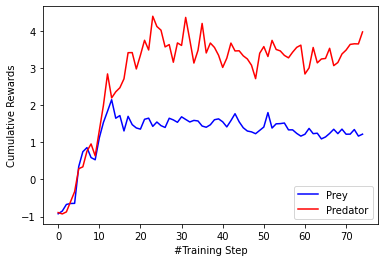

In [27]:
# Trainin Plot
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards_prey, "b", label='Prey')
plt.plot(range(NUM_TRAINING_STEPS), cumulative_rewards_pred, "r", label='Predator')
plt.legend(loc='lower right')
plt.xlabel("#Training Step")
plt.ylabel("Cumulative Rewards")